<a href="https://colab.research.google.com/github/Debarpita02/Quantum-Accelerated-Depression-Diagnosis/blob/main/Quantum_Accelerated_Depression_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Preprocessing***

In [1]:
import numpy as np
import cv2
import zipfile
import io
import os

new_width = 100
new_height = 100

with zipfile.ZipFile('/content/fMRI dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fMRI_dataset_extracted')

dataset_path = '/content/fMRI_dataset_extracted/model/'

def preprocess_image(img):
    img = cv2.resize(img, (new_width, new_height))
    img = img / 255.0
    return img

preprocessed_images = []
emotions = ['afraid', 'calm', 'depressed', 'delighted', 'excited']

for dataset_type in ['train', 'test']:
    for emotion_state in emotions:
        folder_path = os.path.join(dataset_path, dataset_type, emotion_state)

        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            if not os.path.isfile(img_path):
                print(f"File not found: {img_path}")
                continue

            with open(img_path, 'rb') as f:
                img_bytes = f.read()
                nparr = np.frombuffer(img_bytes, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                img = preprocess_image(img)
                preprocessed_images.append(img)

preprocessed_images = np.array(preprocessed_images)


***Feature Extraction***

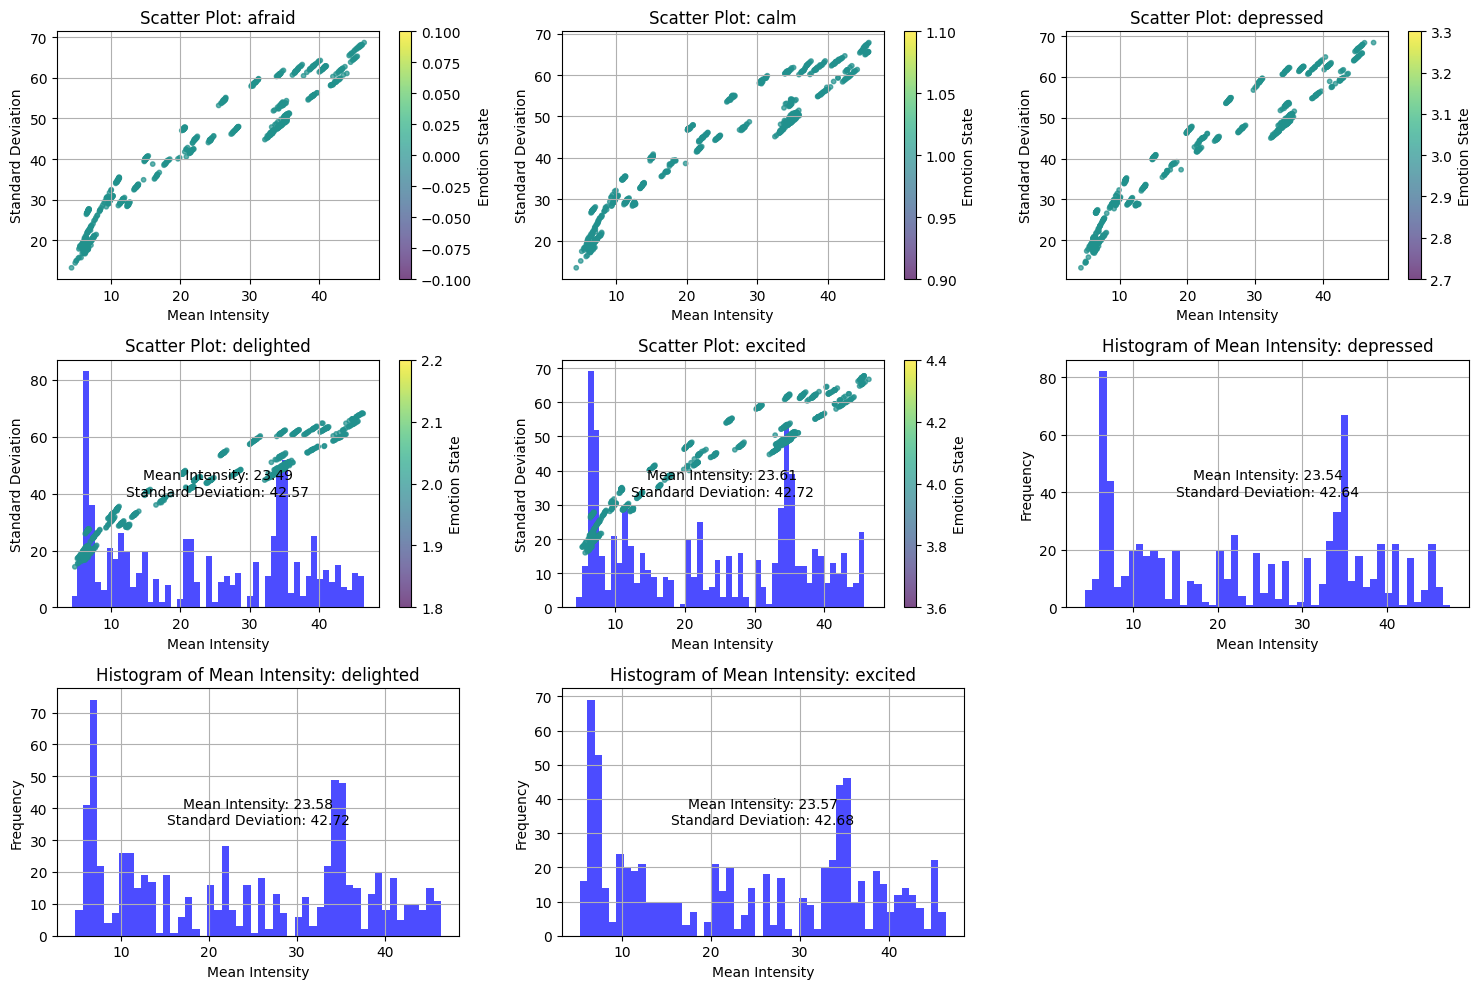

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

new_width = 100
new_height = 100

dataset_path = '/content/fMRI_dataset_extracted/model/'

def extract_features(img):

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)

    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()

    features = np.concatenate(([mean_intensity, std_intensity], hist))
    return features

extracted_features = []
labels = []

for dataset_type in ['train', 'test']:
    for emotion_state in emotions:
        folder_path = os.path.join(dataset_path, dataset_type, emotion_state)

        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, (new_width, new_height))

            features = extract_features(img)

            extracted_features.append(features)

            labels.append(emotion_state)


extracted_features = np.array(extracted_features)
labels = np.array(labels)


label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

plt.figure(figsize=(15, 10))

for i, emotion_state in enumerate(emotions):
    mask = labels == emotion_state
    features_subset = extracted_features[mask]
    labels_subset = integer_labels[mask]

    plt.subplot(3, 3, i+1)
    scatter = plt.scatter(features_subset[:, 0], features_subset[:, 1], c=labels_subset, cmap='viridis', alpha=0.7, s=10)  # Adjust marker size (s)
    plt.title(f'Scatter Plot: {emotion_state}')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Standard Deviation')
    plt.colorbar(label='Emotion State')
    plt.grid(True)

    plt.subplot(3, 3, i+4)
    plt.hist(features_subset[:, 0], bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of Mean Intensity: {emotion_state}')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)

    mean_intensity = np.mean(features_subset[:, 0])
    std_deviation = np.mean(features_subset[:, 1])
    plt.text(0.5, 0.5, f'Mean Intensity: {mean_intensity:.2f}\nStandard Deviation: {std_deviation:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()



***Quantum Computing***

In [3]:
!pip install projectq

from projectq import MainEngine
from projectq.ops import H, X, CNOT, All, Measure
import numpy as np

num_qubits = 4
target_element = 10

def oracle(qubits, target_element):
    for i, qubit in enumerate(qubits):
        if (target_element >> i) & 1:
            X | qubit

def diffusion(qubits):

    All(H) | qubits

    X | qubits[-1]

    for i in range(len(qubits) - 1):
        CNOT | (qubits[i], qubits[-1])

    X | qubits[-1]

    All(H) | qubits[:-1]

def grover_algorithm(num_qubits, target_element, num_iterations):
    engine = MainEngine()

    qubits = engine.allocate_qureg(num_qubits)

    All(H) | qubits

    for _ in range(num_iterations):
        # Apply the oracle
        oracle(qubits, target_element)

        diffusion(qubits)

    All(Measure) | qubits

    engine.flush()

    outcomes = [int(q) for q in qubits]

    return outcomes

num_iterations = 2

num_runs = 10000

measurement_results = []
for _ in range(num_runs):
    measurement_outcomes = grover_algorithm(num_qubits, target_element, num_iterations)
    measurement_results.append(measurement_outcomes)

measurement_distribution = np.array(measurement_results)
unique_outcomes, counts = np.unique(measurement_distribution, axis=0, return_counts=True)

print("Distribution of Measurement Outcomes:")
for outcome, count in zip(unique_outcomes, counts):
    print(f"Measurement outcome: {outcome}, Count: {count}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.7/433.7 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for projectq: filename=projectq-0.8.0-cp310-cp310-linux_x86_64.whl size=2441470 sha256=367acac714fb91a5ddf49fa2e5fecd604c2496a58bb3c1ff1e60aa311fcd04bd
  Stored in directory: /root/.cache/pip/wheels/93/7d/94/e9101f82d3952d893d536e930bc11f1f70b2f44e1b7b8c8b9f
Successfully built projectq
Distribution of Measurement Outcomes:
Measurement outcome: [0 0 0 0], Count: 623
Measurement outcome: [0 0 0 1], Count: 609
Measurement outcome: [0 0 1 0], Count: 654
Measurement outcome: [0 0 1 1], Count: 608
Measurement outcome: [0 1 0 0], Count: 630
Measurement outcome: [0 1 0 1], Count: 689
Measurement outcome: [0 1 1 0], Count: 655
Measurement outcome: [0 1 1 1], Count: 615
Measurement outcome: [1 0 0 0], Count: 657
Measurement outcome: [1 0 0 1], Count: 640
Measurement 

In [4]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

train_dir = '/content/fMRI_dataset_extracted/model/train'
test_dir = '/content/fMRI_dataset_extracted/model/test'

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
}

model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2)

grid_search.fit(X_train_flat, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

model_path = 'random_forest_model.pkl'
joblib.dump(best_model, model_path)
print("Model saved successfully.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Test Accuracy: 0.3435185185185185
Model saved successfully.


In [8]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224))  # Resize image to 224x224 (input size for VGG16)
                images.append(img_resized)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load images from train and test directories
train_dir = '/content/fMRI_dataset_extracted/model/train'
test_dir = '/content/fMRI_dataset_extracted/model/test'
X_train, y_train = load_images_from_folder(train_dir)
X_test, y_test = load_images_from_folder(test_dir)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Load pre-trained VGG16 model (without the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new fully connected layers for our classification task
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 emotions: afraid, calm, depressed, delighted, excited
])

# Compile model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),  # Use SGD optimizer with learning rate 0.001 and momentum 0.9
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20,  # Rotate images by 20 degrees
                             width_shift_range=0.1,  # Shift width by 10%
                             height_shift_range=0.1,  # Shift height by 10%
                             shear_range=0.1,  # Shear transformation by 10%
                             zoom_range=0.1,  # Zoom by 10%
                             horizontal_flip=True,  # Flip horizontally
                             fill_mode='nearest')  # Fill mode for points outside the input boundaries

# Fit the data generator on the training data
datagen.fit(X_train)

# Train model with data augmentation
model.fit(datagen.flow(X_train, y_train_encoded, batch_size=128),  # Use batch size of 128 for faster processing
          steps_per_epoch=len(X_train) / 128,  # Number of batches per epoch
          epochs=10,  # Reduced number of epochs
          validation_data=(X_test, y_test_encoded))

# Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", test_acc)

# Save model
model.save('emotion_classification_model_with_VGG16_optimized.h5')

# Function to predict emotion label for a new image
def predict_emotion(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))  # Resize image to 224x224
    img_input = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    prediction = model.predict(img_input)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

# Example usage
image_path = '/content/Chanvol_125slice_1.png'  # Update with the path to your image
predicted_emotion = predict_emotion(image_path)
print("Predicted Emotion:", predicted_emotion)


Epoch 1/10
19/19 [==============================] - 38s 2s/step - loss: 138.0934 - accuracy: 0.1971 - val_loss: 1.6104 - val_accuracy: 0.2000
Epoch 2/10
19/19 [==============================] - 36s 2s/step - loss: 1.6106 - accuracy: 0.2003 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 3/10
19/19 [==============================] - 36s 2s/step - loss: 1.6101 - accuracy: 0.2003 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 4/10
19/19 [==============================] - 36s 2s/step - loss: 1.6098 - accuracy: 0.2003 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 5/10
19/19 [==============================] - 35s 2s/step - loss: 1.6097 - accuracy: 0.1864 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 6/10
19/19 [==============================] - 36s 2s/step - loss: 1.6096 - accuracy: 0.1948 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 7/10
19/19 [==============================] - 36s 2s/step - loss: 1.6095 - accuracy: 0.1940 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 8/10
19/19 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 221ms/step
Predicted Emotion: ['depressed']
